In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import json
import datetime


file_name = "labeled_images.h5"

base_dir = "./"+file_name

with open("labaled_data.json", "r") as outfile:
    pointcloud_data = json.load(outfile)

classes = set()
for i in pointcloud_data:
    classes.add(pointcloud_data.get(i)[1])
classes = list(classes)


In [2]:
#split data into training and validation if neccessary
SPLIT_RATIO = 0.8
with h5py.File(file_name, "r") as file:
    c = list(zip(list(file['images']),list(file['labels'])))
    sz = len(c)
    cut = int(sz*SPLIT_RATIO)
    random.shuffle(c)

    training=c[:cut]
    testing=c[cut:]
    
    training_data=[]
    training_labels=[]
    testing_data=[]
    testing_labels=[]

    for a in training:
        training_data.append(a[0])
        training_labels.append(a[1])

    for a in testing:
        testing_data.append(a[0])
        testing_labels.append(a[1])

training_x=np.array(training_data)
training_labels=np.array(training_labels)
training_data = tf.data.Dataset.from_tensor_slices((training_x, training_labels))
testing_x=np.array(testing_data)
testing_labels=np.array(testing_labels)
testing_data = tf.data.Dataset.from_tensor_slices((testing_x, testing_labels))
display(training_data, testing_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [3]:

IMAGE_SIZE = 255

BATCH_SIZE = 32

input_shape = training_x.shape[1:]

train_dataset = training_data.batch(BATCH_SIZE)
# display(input_shape)
inputs = keras.Input(shape=input_shape)


x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
base_model = keras.applications.ResNet50V2(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=2
)(x)

model_name = "RESNET50V2_open_close_mouth"

model = keras.Model(inputs, base_model, name=model_name)
model.compile(optimizer=keras.optimizers.experimental.RMSprop(learning_rate=0.001), 
              loss="sparse_categorical_crossentropy", 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
checkpoint_filepath = "./checkpoint_/"+model_name
# data_generator.fit(training_data)

# display(training_data.shape)
# display(training_labels.shape)

# for image_batch, label_batch in train_generator:
#     break

In [4]:
try:
    model.load_weights("./weights/"+ model_name)
except:
    print("no weights")
    
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history = model.fit(train_dataset, epochs=20, validation_data=(testing_x, testing_labels), callbacks=[model_checkpoint_callback,tensorboard_callback])


model.save_weights("./weights/"+ model_name)

Epoch 1/30
17/17 [==============================] - 24s 422ms/step - loss: 0.4912 - sparse_categorical_accuracy: 0.9144 - val_loss: 0.3468 - val_sparse_categorical_accuracy: 0.9318
Epoch 2/30
17/17 [==============================] - 5s 270ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.5468 - val_sparse_categorical_accuracy: 0.8939
Epoch 3/30
17/17 [==============================] - 5s 277ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.9242
Epoch 4/30
17/17 [==============================] - 5s 270ms/step - loss: 0.0034 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2519 - val_sparse_categorical_accuracy: 0.9318
Epoch 5/30
17/17 [==============================] - 5s 322ms/step - loss: 5.5844e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2692 - val_sparse_categorical_accuracy: 0.9394
Epoch 6/30
17/17 [==============================] - 5s 271ms/step - loss: 1.4415e-04 - sparse_c

In [5]:
results = model.evaluate(testing_x, testing_labels, batch_size=16)
print("test loss, test acc:", results)

9/9 [==============================] - 1s 22ms/step - loss: 0.3073 - sparse_categorical_accuracy: 0.9242
test loss, test acc: [0.30734261870384216, 0.9242424368858337]


1/1 [==============================] - 1s 788ms/step
classes:closed_mouth, open_mouth
predictions: [[0.01448853 0.98551154]]
actual: [1]


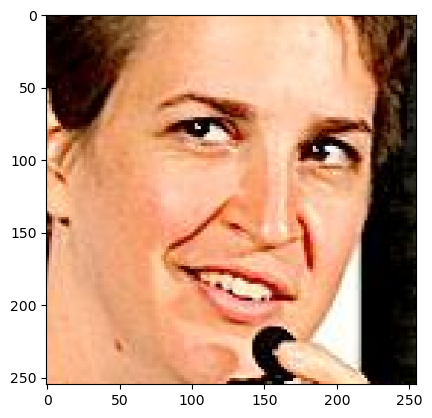

In [6]:
from matplotlib import pyplot as plt
index_start = 32
index_end = index_start+1
predictions = model.predict(testing_x[index_start:index_end])
print("classes:" +classes[0] +", "+ classes[1] )
# print("predictions shape:", predictions.shape)
print("predictions:", predictions)
print("actual:", testing_labels[index_start:index_end])

plt.imshow(testing_x[index_start], interpolation='nearest')
plt.show()